<a href="https://colab.research.google.com/github/khchu93/ComputerVision/blob/main/Faster_R_CNN_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Faster R-CNN


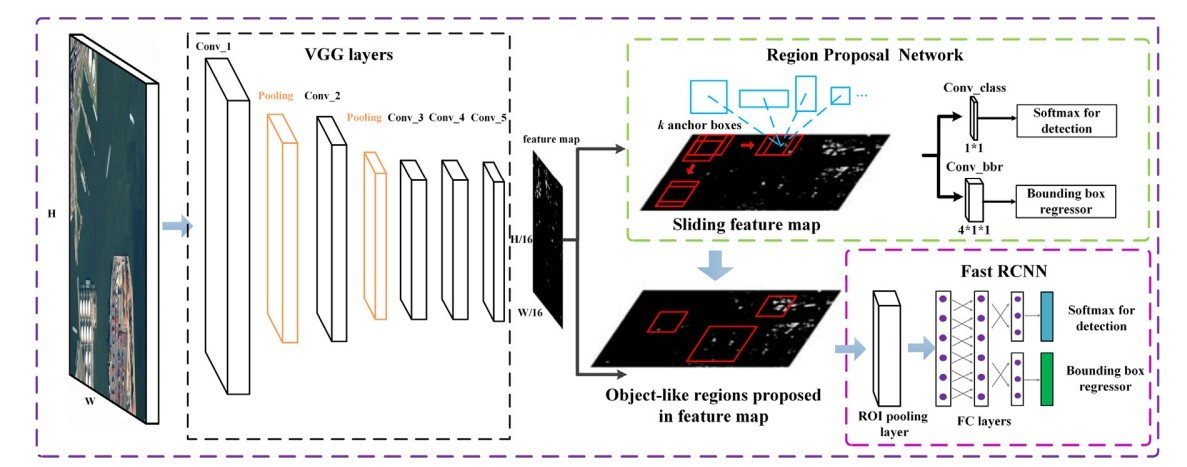

###Background

Faster R-CNN is a region proposal–based CNN model published in 2015. It was a state-of-the-art (SOTA) object detection framework at the time of its release and is still widely used today.

Although Faster R-CNN is no longer the first choice for most real-time or large-scale tasks due to newer models offering faster inference and comparable accuracy, but it remains a strong choice for accuracy-focused, research, or domain-specific applications.

### Model

Overview<br>
Faster R-CNN is a two-stage object detection framework composed of a Region Proposal Network (RPN) and a Fast R-CNN classifier. It is designed to detect objects efficiently and accurately by combining proposal generation and classification in a single, end-to-end trainable model.

Region Proposal Network (RPN)<br>
The RPN generates candidate object regions directly from convolutional feature maps, replacing slow, CPU-based external proposal methods such as selective search. Anchors of various scales and aspect ratios are placed on the feature map, and each predicts an objectness score and bounding box offsets. Anchors with high overlap (IoU) with ground truth boxes are treated as positive, guiding both classification and localization, while anchors with low IoU are treated as negatives. This enables the network to propose regions likely to contain objects in a fully trainable and GPU-parallelizable manner.

Fast R-CNN Classifier<br>
The Fast R-CNN component refines the proposals from the RPN. Each proposed region is mapped onto the shared feature map, and a RoI Pooling or RoI Align layer extracts a fixed-size feature vector for the region. These features are passed through fully connected layers to predict class scores and adjust bounding box coordinates, producing precise object detections. By sharing convolutional features between the RPN and classifier, Faster R-CNN achieves both high accuracy and computational efficiency.

Key Concepts<br>
The framework combines coarse-to-fine localization with end-to-end training. Anchors provide multiple scales and aspect ratios to capture diverse object sizes. RoI pooling standardizes proposal features, and the shared backbone reduces redundant computation, making Faster R-CNN significantly faster than earlier two-stage detectors while maintaining high detection performance.


###Steps
####Region proposal network
1. <u>Extract shared feature map (Backbone)</u>:  
    - Pass the input image through a backbone network (e.g., ResNet) to obtain a feature map.
    - Focus: Capture high-level features from the image for both RPN and ROI classifier.
2. <u>Generate anchor boxes</u>:
    - Generate multiple anchor boxes of different scales and aspect ratios at each spatial location of the feature map.
    - Focus: Provide candidate bounding boxes that may contain objects.
3. <u>Project ground truth boxes to feature map scale</u>:
    - Scale ground truth boxes to match the feature map resolution.
    - Focus: Align GT boxes with anchor coordinates for IoU calculation.
Question : what is the offset for?
4. <u>Assign positive and negative anchors</u>:
    - Compute IoU between all anchors and GT boxes.
    - Mark anchors as positive if they overlap most with a GT box or exceed a threshold; mark as negative if IoU is low.
    - Focus: Define which anchors contribute to RPN classification and regression.
5. <u>Predict objectness and offsets (RPN)</u>:
    - Pass the feature map through a small convolutional network to predict:
      - Objectness scores (foreground/background)
      - Box offsets (regression to refine anchors)
    - Focus: Learn which anchors contain objects and how to adjust them.
6. <u>Compute RPN loss</u>:
    - Use cross-entropy for objectness and smooth L1 for offsets.
    - Focus: Train the RPN to propose good candidate boxes.
7. <u>Generate proposals and apply NMS</u>:
    - Adjust positive anchors using predicted offsets to create region proposals.
    - Apply confidence thresholding and Non-Maximum Suppression (NMS) to reduce redundancy.
    - Focus: Produce high-quality candidate regions for classifier.

####Fast R-CNN<br>
8. <u>ROI pooling / align proposals</u>:
    - Crop features corresponding to proposals and resize them to a fixed size using ROI pooling.
    - Focus: Extract uniform feature representations for each proposal.
9. <u>Classifier forward</u>:
    - Pass ROI-pooled features through fully connected layers to predict object classes.
    - Focus: Determine the category of each proposal.
10. <u>Compute classification loss</u>:
    - Cross-entropy loss comparing predicted classes to GT classes.
    - Focus: Train classifier to correctly identify object categories.
11. <u>Compute total loss</u>:
    - Combine RPN loss and classification loss for end-to-end training.
    - Focus: Optimize both proposal generation and object classification jointly.

####Inference    
12. <u>Inference</u>:
    - During testing, generate proposals with RPN, classify them with the classifier, and apply confidence thresholds and NMS.
    - Focus: Output final bounding boxes and predicted classes per image.


P.S. The following Faster RCNN implementation is adapted from publicly available [online resources](https://medium.com/data-science/understanding-and-implementing-faster-r-cnn-a-step-by-step-guide-11acfff216b0). I have added detailed annotations, explanations, and minor modifications to document my understanding of the underlying concepts.

##Implementation

###Step 0: Prepare and load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

####Parse annotation from XML to elementTree

In [ ]:
import xml.etree.ElementTree as ET

def parse_annotation(annotation_path, image_dir, img_size):
  '''
  Transform annotations format from XML to elementTree format, and extract resized gt bbox and gt labels for each image

  Args:
    annotation_path (str): path to annotation file
    image_dir (str): path to image directory
    img_size (tuple): desired image size
  Returns:
    gt_boxes_all (torch.Tensor of shape [nb of image, nb of bbox, bbox location]): list of all the ground truth boxes in tensor
    gt_classes_all (torch.Tensor of shape [nb of image, nb of bbox]): list of all the ground truth classes
    img_paths (list[str] of shape [nb of image]): list of all the image paths
  '''
  img_h, img_w = img_size
  # open annotation in read mode as a file object and parse it into ElementTree object
  with open(annotation_path, "r") as f:
    tree = ET.parse(f)
  root = tree.getroot()

  img_paths = []
  gt_boxes_all = []
  gt_classes_all = []
  # get bounding box and label
  for object_ in root.findall('image'):
    img_path = os.path.join(image_dir, object_.get("name"))
    img_paths.append(img_path)

    # get raw image size
    orig_w = int(object_.get("width"))
    orig_h = int(object_.get("height"))

    # get bboxes and their labels, rescale bbox's shape
    groundtruth_boxes = []
    groundtruth_classes = []
    for box_ in object_.findall('box'):
      xmin = float(box_.get("xtl"))
      ymin = float(box_.get("ytl"))
      xmax = float(box_.get("xbr"))
      ymax = float(box_.get("ybr"))

      # rescale bboxes according to the new uniform image shape
      bbox = torch.Tensor([xmin, ymin, xmax, ymax])
      bbox[[0, 2]] = bbox[[0, 2]] * img_w/orig_w
      bbox[[1, 3]] = bbox[[1, 3]] * img_h/orig_h
      groundtruth_boxes.append(bbox.tolist())

      # get labels
      label = box_.get("label")
      groundtruth_classes.append(label)

    gt_boxes_all.append(torch.Tensor(groundtruth_boxes))
    gt_classes_all.append(groundtruth_classes)

  return gt_boxes_all, gt_classes_all, img_paths

####Create a class to better organize and load info for images

PyTorch **pad_sequence()** is used to pad all ground truth bounding boxes and labels to match the largest number of boxes in a batch, allowing them to be stacked into a single tensor for training.

`pad_sequence()` takes a list of tensors (each one can have a different length)
and pads them to the same length with zeros (by default).
```
torch.nn.utils.rnn.pad_sequence(
    sequences,          # A list of variable-length tensors to be padded (each tensor should have the same shape except for the first dimension (sequence length))
    batch_first=False,  # Decide whether the first dimension should be time/sequence(= False) or batch(= True)
    padding_value=0.0   # Value to use for padding (default: 0.0))
```

In [ ]:
class ObjectDetectionDataset(Dataset):
  '''
  A Pytorch Dataset class to load the images and their corresponding annotations.
  '''
  def __init__(self, annotation_path, img_dir, img_size, name2idx):
    '''
    Constructor

    Args:
      annotation_path (str): path to annotation file
      img_dir (str): path to image directory
      img_size (tuple): desired image size
      name2idx (dict): mapping of class names to integers
    Returns:
      None
    '''
    self.annotation_path = annotation_path
    self.img_dir = img_dir
    self.img_size = img_size
    self.name2idx = name2idx

    self.img_data_all, self.gt_bboxes_all, self.gt_classes_all = self.get_data()

  def __len__(self):
    '''
    Returns the length of the dataset

    Args:
      None
    Returns:
      length of the dataset
    '''
    return self.img_data_all.size(dim=0)

  def __getitem__(self, idx):
    '''
    Returns the image and its corresponding gt bbox(s) + gt label(s)

    Args:
      idx (int): index of the image in the dataset
    Returns:
      img_data (torch.Tensor in shape [batch size(/number of image), number of channel, image height, image weigt]): image data
      gt_bboxes (torch.Tensor in shape [batch size(/number of image), number of channel, image height, image weigt]): ground truth bounding boxes
      gt_classes (torch.Tensor in shape [batch size, max bbox]): ground truth classes
    '''
    return self.img_data_all[idx], self.gt_bboxes_all[idx], self.gt_classes_all[idx]

  def get_data(self):
    '''
    Load the images and their corresponding paddded gt bbox(s) and padded gt label(s)

    Args:
      None
    Returns:
      img_data_stacked (torch.Tensor in shape [batch size(/number of image), number of channel, image height, image weigt]): image data
      gt_bboxes_pad (torch.Tensor in shape [batch size(/number of image), number of channel, image height, image weigt]): ground truth bounding boxes
      gt_classes_pad (torch.Tensor in shape [batch size, max bbox]): ground truth classes
    '''
    img_data_all = []
    gt_idxs_all = []

    gt_boxes_all, gt_classes_all, img_paths = parse_annotation(self.annotation_path, self.img_dir, self.img_size)

    for i, img_path in enumerate(img_paths):

      # skip if the image path is not valid
      if (not img_path) or (not os.path.exists(img_path)):
          continue

      # read and resize image
      img = io.imread(img_path)
      img = resize(img, self.img_size)

      # convert image to torch tensor and reshape it so channels come first
      img_tensor = torch.from_numpy(img).permute(2, 0, 1)

      # encode class names as integers
      gt_classes = gt_classes_all[i]
      gt_idx = torch.Tensor([self.name2idx[name] for name in gt_classes])

      img_data_all.append(img_tensor)
      gt_idxs_all.append(gt_idx)

    # pad all bounding boxes and classes to match the largest number of boxes/labels in a batch in order to stack them
    # the non-existed bounding boxes and classes are padded to category "pad" (-1)
    gt_bboxes_pad: torch.Tensor = pad_sequence(gt_boxes_all, batch_first=True, padding_value=-1)
    gt_classes_pad: torch.Tensor = pad_sequence(gt_idxs_all, batch_first=True, padding_value=-1)

    # stack all images
    img_data_stacked: torch.Tensor = torch.stack(img_data_all, dim=0)

    return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad

In [ ]:
img_width: int = 640
img_height: int = 480
annotation_path: str = "/content/drive/MyDrive/AI Dataset/Faster_R-CNN/annotations.xml"
image_dir: str = os.path.join("/content/drive/MyDrive/AI Dataset/Faster_R-CNN", "images")
name2idx: dict = {'pad': -1, 'camel': 0, 'bird': 1}
idx2name: dict = {v:k for k, v in name2idx.items()}

We wrap the dataset with PyTorch **dataLoader()** here for efficency. `DataLoadder()` <u>handles how to batch and feed data to the model efficiently</u> (e.g., Batching, Shuffling, Parallel loading).
```
torch.nn.utils.rnn.DataLoader(
    dataset,               # Your custom or built-in Dataset object
    batch_size  = 32,      # Number of samples per batch
    shuffle     = True,    # Randomly shuffle data each epoch
    num_workers = 4,       # How many CPU workers to use for loading
    pin_memory  = True,    # Speeds up GPU data transfer
    drop_last   = False,   # Drop the last incomplete batch            
    collate_fn  = None     # Custom function to merge samples (important for variable-size inputs, e.g. bounding boxes))
```

In [ ]:
# Parse the dataset and wraps it with dataloader
od_dataset    : ObjectDetectionDataset = ObjectDetectionDataset(annotation_path, image_dir, (img_height, img_width), name2idx)
od_dataloader : DataLoader = DataLoader(od_dataset, batch_size=2) # 2 samples per batch

####Sample the first batch and display it with annotations

In [ ]:
# extract the first batch from od_dataloader
for img_batch, gt_bboxes_batch, gt_classes_batch in od_dataloader:
  img_data_all: torch.Tensor = img_batch
  gt_bboxes_all: torch.Tensor = gt_bboxes_batch
  gt_classes_all: torch.Tensor = gt_classes_batch
  break

print(f"Ground truth bounding boxes of batch 1 in shape [batch size, max bbox, bbox location(x1, y1, x2, y2)]: \
      \n{gt_bboxes_all.shape}\n{gt_bboxes_all}\n")
print(f"Ground truth labels of batch 1 in shape [batch size, max bbox]: \
      \n{gt_classes_all.shape}\n{gt_classes_all}\n")
print(f"Images of batch 1 in shape [batch size, nb of channel, image height, image weight]: \
      \n{img_data_all.shape}")

# sample only the first two images (since there is only two images in the dataset, nothing will change)
img_data_all = img_data_all[:2]
gt_bboxes_all = gt_bboxes_all[:2]
gt_classes_all = gt_classes_all[:2]

Ground truth bounding boxes of batch 1 in shape [batch size, max bbox, bbox location(x1, y1, x2, y2)]:       
torch.Size([2, 6, 4])
tensor([[[ 32.2824,  65.2389, 328.1725, 352.8849],
         [408.5333, 148.9911, 612.8032, 368.4920],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000]],

        [[413.2392, 208.3540, 566.8173, 323.4655],
         [215.0368, 221.7805, 418.7608, 446.4885],
         [182.7765,  53.6920, 348.1380, 213.6991],
         [ 58.8863, 116.6513, 271.8745, 307.2566],
         [281.0667, 182.5133, 429.0196, 273.1859],
         [ 65.0447, 322.8672, 226.2996, 453.4159]]])

Ground truth labels of batch 1 in shape [batch size, max bbox]:       
torch.Size([2, 6])
tensor([[ 0.,  0., -1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.]])

Images of batch 1 in shape [batch size, nb of channel, image height, image weig

In [ ]:
# get class names (convert int to str) for image 1 and 2
gt_class_1: list[int] = gt_classes_all[0].long()  # create a new tensor and convert it to long
gt_class_1: list[str] = [idx2name[idx.item()] for idx in gt_class_1]  # convert int to str class name

gt_class_2: list[int] = gt_classes_all[1].long()
gt_class_2: list[str] = [idx2name[idx.item()] for idx in gt_class_2]

In [ ]:
def display_img(img_data, fig, axes):
  """
  Reorder img shape to numpy and show all images

  Args:
    img_data (torch.Tensor): image in tensor format
    fig (plt.figure): figure object
    axes (plt.axes): axes object
  Returns:
    fig (plt.figure): updated figure object
    axes (plt.axes): updated axes object
  """
  for i, img in enumerate(img_data):
    if type(img) == torch.Tensor:
      img = img.permute(1, 2, 0).numpy()  # reorder img shape from tensor'd diemension(C, H, W) to numpy format(H, W, C)
    axes[i].imshow(img)
  return fig, axes

def display_bbox(bboxes, fig, ax, classes=None, in_format='xyxy', color='y', line_width=3):
  """
  draw bounding boxes with category on images

  Args:
    bboxes (torch.Tensor): bounding boxes in tensor format
    fig (plt.figure): figure object
    ax (plt.axes): axes object
    classes (list[str]): list of class
    in_format (str): desired bbox format
    color (str): color of the bounding box
    line_width (int): line width of the bounding box
  Returns:
    fig (plt.figure): updated figure object
    ax (plt.axes): updated axes object
  """
  # if bboxes are in numpy array, change it to pytorch tensor
  if type(bboxes) == np.ndarray:
      bboxes = torch.from_numpy(bboxes)
  # raise error if number of bounding boxes and number of their corresponding labels are different
  if classes:
      assert len(bboxes) == len(classes)
  # convert boxes to xywh format
  bboxes = ops.box_convert(bboxes, in_fmt=in_format, out_fmt='xywh')
  c = 0
  for box in bboxes:
    x, y, w, h = box.numpy()
    # display bounding box
    rect = patches.Rectangle((x, y), w, h, linewidth=line_width, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    # display category
    if classes:
      if classes[c] == 'pad':
        continue
      ax.text(x + 5, y + 20, classes[c], bbox=dict(facecolor='yellow', alpha=0.5))
    c += 1

  return fig, ax

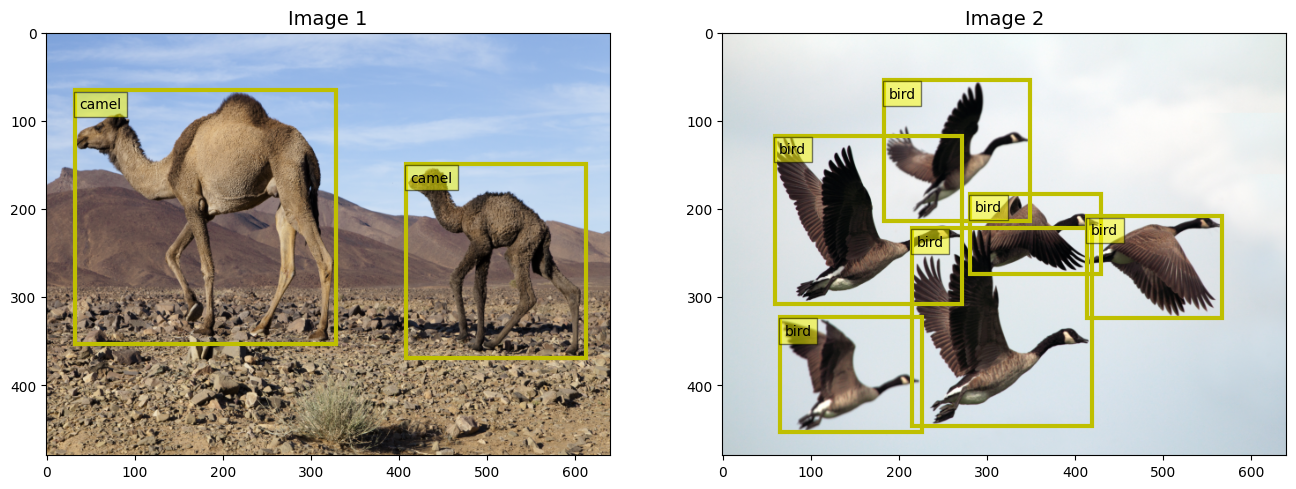

In [ ]:
# sample the image input with annotation
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

# display image with bounding boxes and category
fig, axes = display_img(img_data_all, fig, axes)
axes[0].set_title("Image 1", fontsize=14)
axes[1].set_title("Image 2", fontsize=14)
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0], classes=gt_class_1)
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1], classes=gt_class_2)

###Step 1: Extract shared feature map (Backbone)

In [ ]:
class FeatureExtractor(nn.Module):
  """
  Backbone feature extractor using pretrained ResNet50.
  Extracts convolutional feature maps for RPN.
  """
  def __init__(self):
    super().__init__()
    model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
    # Take first 8 layers (up to last conv block before avgpool)
    req_layers = list(model.children())[:8]
    self.backbone = nn.Sequential(*req_layers)
    # Allow gradient updates
    for _, param in self.backbone.named_parameters():
        param.requires_grad = True

  def forward(self, img_data):
    # Input: [B, C, H, W]
    # Output: [B, C', H', W']
    return self.backbone(img_data)

In [ ]:
from torchsummary import summary

backbone = FeatureExtractor()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone.to(device)
img_data_all = img_data_all.to(device)

# run the image through the backbone to extract shared feature map
out = backbone(img_data_all)
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)
print(f"\nModel summary:")
summary(backbone, input_size=(3, 224, 224))        # print model
print(f"\nShared feature map's shape (nb of channels, feature map height, feature map width): ({out_c}, {out_h}, {out_w})")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]



Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14   

In [ ]:
# calculate how much the images has been down scaled
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
print(f"Images has been down-scaled by (height, width): ({height_scale_factor}, {width_scale_factor})")

Images has been down-scaled by (height, width): (32, 32)


##### Display the extracted feature map

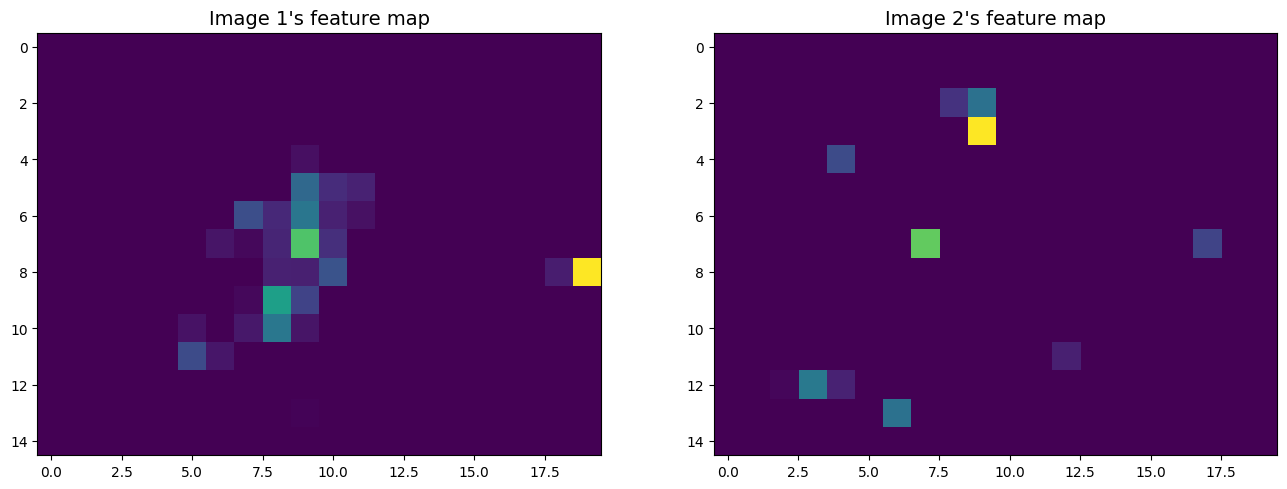

In [ ]:
# display the extracted feature map of each image
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
filters_data =[filters[0].detach().cpu().numpy() for filters in out[:2]]
fig, axes = display_img(filters_data, fig, axes)
axes[0].set_title("Image 1's feature map", fontsize=14)
axes[1].set_title("Image 2's feature map", fontsize=14)
plt.show()

The feature maps show varying activation patterns across the image. Regions containing objects often display high values in channels that learned to detect object-relevant features like specific shapes textures, and patterns. However, "empty" regions (like sky or ground) also show high activations because the pre-trained ResNet50 learned to recognize ALL visual patterns during ImageNet training, not just objects. These background regions activate channels sensitive to contextual features like colors, textures, and semantic scene elements (e.g., "sky-ness" or "ground-ness"). The backbone extracts rich representations of the entire image—it's the subsequent Faster R-CNN components (RPN and detection head) that learn to distinguish which patterns correspond to objects versus background.

###Step 2: Generate anchor boxes

In [ ]:
def gen_anc_centers(out_size):
  """
  Generate anchor center points on a grid where each cell is 1x1 unit with center at (0.5, 0.5) of each cell

  Args:
    out_size (list(int) in shape [2]): height and weight of the shared feature map (Backbone output)
  Returns:
    anc_pts_x (torch.Tensor in shape [feature map height]): x coordinates of anchor centers
    anc_pts_y (torch.Tensor in shape [feature map weight]): y coordinates of anchor centers
  """
  out_h, out_w = out_size

  anc_pts_x = torch.arange(0, out_w) + 0.5
  anc_pts_y = torch.arange(0, out_h) + 0.5

  return anc_pts_x, anc_pts_y

In [ ]:
def display_grid(x_points, y_points, fig, ax, special_point=None):
    """
    Display grid of anchor centers

    Args:
      x_points (torch.Tensor in shape [feature map height]): x coordinates of anchor centers
      y_points (torch.Tensor in shape [feature map weight]): y coordinates of anchor centers
      fig (plt.figure): figure object
      ax (plt.axes): axes object
      special_point (tuple): (x, y) coordinates of a special point
    Returns:
      fig (plt.figure): updated figure object
      ax (plt.axes): updated axes object
    """
    # plot grid
    for x in x_points:
        for y in y_points:
            ax.scatter(x, y, color="w", marker='+')

    # plot a special point we want to emphasize on the grid
    if special_point:
        x, y = special_point
        ax.scatter(x, y, color="red", marker='+')

    return fig, ax

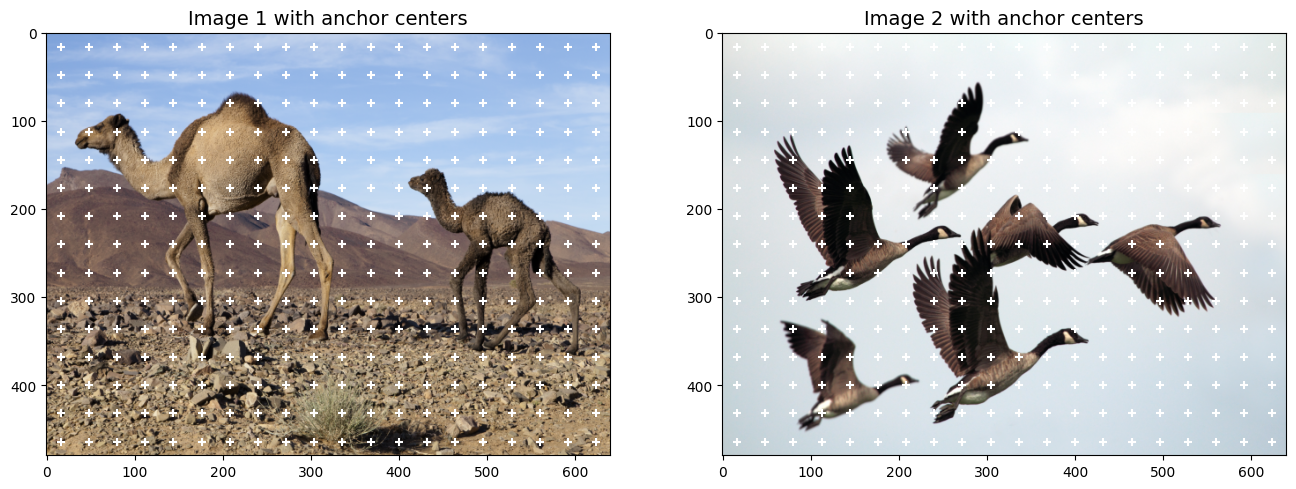

In [ ]:
# mark the anchor center
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

# display the anchor centers on the images
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
fig, axes = display_img(img_data_all.cpu(), fig, axes)
axes[0].set_title("Image 1 with anchor centers", fontsize=14)
axes[1].set_title("Image 2 with anchor centers", fontsize=14)
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])
plt.show()

In [ ]:
def gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, out_size):
  """
  Generate anchor boxes for each spatial location on the feature map

  Args:
    anc_pts_x (torch.Tensor in shape [feature map height]): x coordinates of anchor centers
    anc_pts_y (torch.Tensor in shape [feature map weight]): y coordinates of anchor centers
    anc_scales (list[int]): list of anchor scales to generate
    anc_ratios (list[int]): list of anchor ratios to generate
    out_size (list(int) in shape [2]): height and weight of the feature map
  Returns:
    anc_base (torch.Tensor) in shape [nb set of anc, x coodinates of anchor, y coodinates of anchor, nb of anchor boxes, anchor boxes positions]: anchor boxes for anchor centers
  """
  n_anc_boxes: int = len(anc_scales) * len(anc_ratios)   # nb of anchor box per center = nb of scales * nb of ratios
  nb_set_of_anc_boxes: int = 1  # number of set of anchor boxes: 1 set
  anc_box_position: int = 4     # anchor box position: [x1, y1, x2, y2]
  anc_base: torch.Tensor = torch.zeros(nb_set_of_anc_boxes, anc_pts_x.size(dim=0), anc_pts_y.size(dim=0), n_anc_boxes, anc_box_position)

  for ix, xc in enumerate(anc_pts_x):
    for jx, yc in enumerate(anc_pts_y):
      anc_boxes: torch.Tensor = torch.zeros((n_anc_boxes, anc_box_position))
      c = 0
      # calculate the location of each anchor box
      for i, scale in enumerate(anc_scales):
        for j, ratio in enumerate(anc_ratios):
          w = scale * ratio
          h = scale

          xmin = xc - w / 2
          ymin = yc - h / 2
          xmax = xc + w / 2
          ymax = yc + h / 2

          anc_boxes[c, :] = torch.Tensor([xmin, ymin, xmax, ymax])
          c += 1
        # clips bounding box coordinates to ensure they stay within image boundaries(out_size), clip it to the boundary when it exceeds
        # [1, 9, 4] = [9, 4],  PyTorch broadcasts(= copied to more position) the right side to match the left side
        anc_base[:, ix, jx, :] = ops.clip_boxes_to_image(anc_boxes, size=out_size)

  return anc_base

In [ ]:
# define the anchor boxes to be used: 3(ratio) x 3(scale) = 9 anchor boxes
anc_scales: list[int] = [2, 4, 6]
anc_ratios: list[int] = [0.5, 1, 1.5]
n_anc_boxes: int      = len(anc_scales) * len(anc_ratios) # number of anchor boxes for each anchor point (number of combination)

anc_base: torch.Tensor = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))
print(f"anc_base.shape = [nb set of anc, x coodinates of anchor, y coodinates of anchor, nb of anchor boxes, anchor boxes positions]: \n{anc_base.shape}")

# repeat the anc_base [2, 1, 1, 1, 1] times along the axis = repeat two times on the axis 0 (two images) and do nothing for the rest
anc_boxes_all: torch.Tensor = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)
print(f"\nanc_boxes_all.shape = [nb of images, x coodinates of anchor, y coodinates of anchor, nb of anchor boxes, anchor boxes positions]: \n{anc_boxes_all.shape}")

anc_base.shape = [nb set of anc, x coodinates of anchor, y coodinates of anchor, nb of anchor boxes, anchor boxes positions]: 
torch.Size([1, 20, 15, 9, 4])

anc_boxes_all.shape = [nb of images, x coodinates of anchor, y coodinates of anchor, nb of anchor boxes, anchor boxes positions]: 
torch.Size([2, 20, 15, 9, 4])


###Step 3: Project GT boxes to feature map scale


In [ ]:
def project_bboxes(bboxes, width_scale_factor, height_scale_factor, mode='a2p'):
  """
  Project bounding boxes from activation map(/feature map) to image scale, or vice versa

  Args:
    bboxes (torch.Tensor): bounding boxes in shape [nb set of anc, x coodinates of anchor, y coodinates of anchor, nb of anchor boxes, anchor boxes positions]
  Returns:
    proj_bboxes (torch.Tensor): bounding boxes in shape [nb set of anc, x coodinates of anchor, y coodinates of anchor, nb of anchor boxes, anchor boxes positions]
  """
  # mode must be either a2p or p2a, error otherwise
  assert mode in ['a2p', 'p2a']

  batch_size: int = bboxes.size(dim=0)
  proj_bboxes: torch.Tensor = bboxes.clone().reshape(batch_size, -1, 4) # flatten bboxes to [2, N, 4] to rescale the bboxes scale
  invalid_bbox_mask: torch.Tensor = (proj_bboxes == -1) # element-wise comparison to identify padded bounding boxes in tensor

  if mode == 'a2p':
      # activation map to pixel image
      proj_bboxes[:, :, [0, 2]] *= width_scale_factor
      proj_bboxes[:, :, [1, 3]] *= height_scale_factor
  else:
      # pixel image to activation map
      proj_bboxes[:, :, [0, 2]] /= width_scale_factor
      proj_bboxes[:, :, [1, 3]] /= height_scale_factor

  proj_bboxes.masked_fill_(invalid_bbox_mask, -1) # fill padded bboxes back with -1
  proj_bboxes.resize_as_(bboxes)  # resize it back to [2, 20, 15, 9 , 4]

  return proj_bboxes

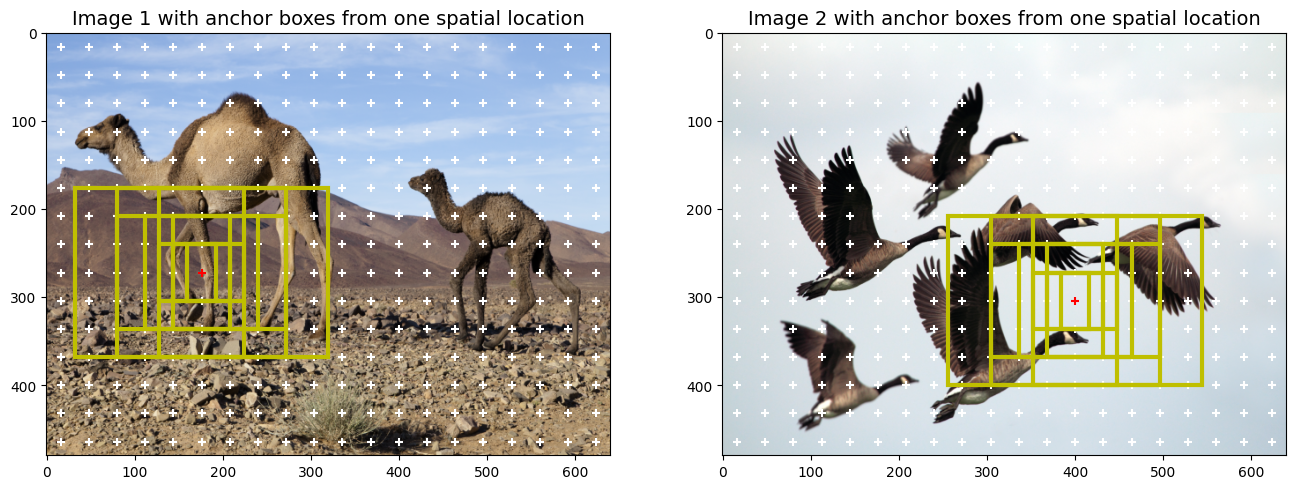

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
fig, axes = display_img(img_data_all.cpu(), fig, axes)

# plot anchor boxes around selected anchor points
sp_1 = [5, 8]     # in feature map scale
sp_2 = [12, 9]    # in faeture map scale

# project anchor boxes to the image scale
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')
bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]  # in image scale
bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]  # in image scale

# display the images with a set of 9 anchors of each anchor points
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1], (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]))
fig, _ = display_bbox(bboxes_1, fig, axes[0])
fig, _ = display_bbox(bboxes_2, fig, axes[1])
axes[0].set_title("Image 1 with anchor boxes from one spatial location", fontsize=14)
axes[1].set_title("Image 2 with anchor boxes from one spatial location", fontsize=14)
plt.show()

We define anchor boxes using 3 scales (2, 4, 6) and 3 aspect ratios (0.5, 1, 1.5), resulting in 9 anchor boxes per spatial location with unique shape (above). Given a feature map of size 20×15 (i.e., 300 locations), a total of 2700 anchor boxes are generated over the entire image. When all the anchor boxes overlap, it will look like the below iamge.

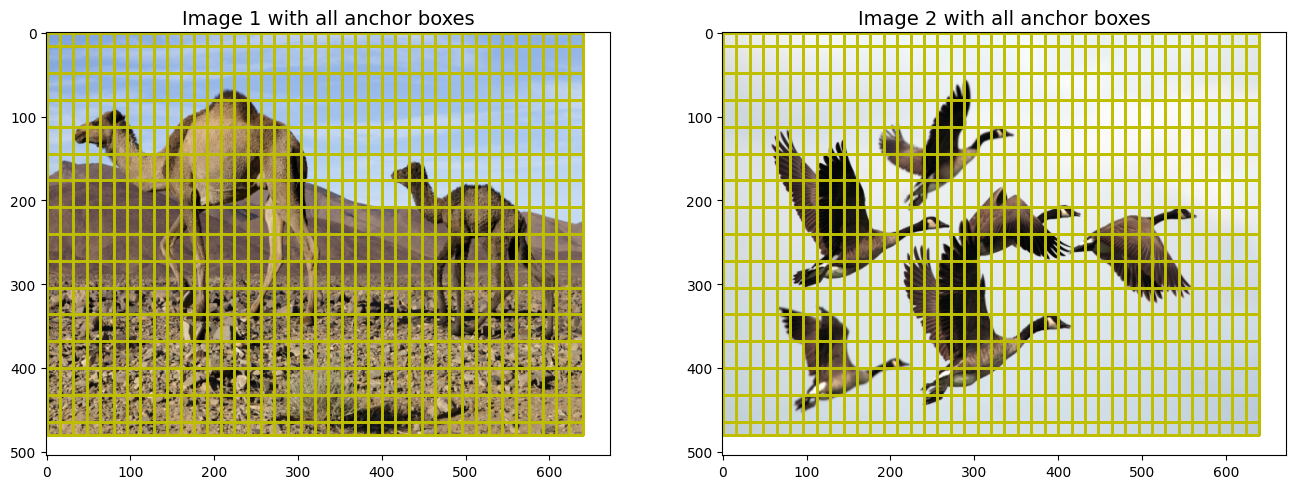

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
#display image
fig, axes = display_img(img_data_all.cpu(), fig, axes)

# plot feature grid
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

# plot all anchor boxes
for x in range(anc_pts_x_proj.size(dim=0)):
    for y in range(anc_pts_y_proj.size(dim=0)):
        bboxes = anc_boxes_proj[0][x, y]
        fig, _ = display_bbox(bboxes, fig, axes[0], line_width=1)
        fig, _ = display_bbox(bboxes, fig, axes[1], line_width=1)
axes[0].set_title("Image 1 with all anchor boxes", fontsize=14)
axes[1].set_title("Image 2 with all anchor boxes", fontsize=14)
plt.show()

###Step 4: Assign positive and negative anchors


In [ ]:
def get_iou_mat(batch_size, anc_boxes_all, gt_bboxes_all):
  """
  Calculate IoU matrix between anchor boxes and ground truth boxes

  Args:
    batch_size (int): number of images
    anc_boxes_all (torch.Tensor in shape [batch_size, w_amap, h_amap, n_anchor_boxes, 4]): anchor boxes
    gt_bboxes_all (torch.Tensor in shape [batch_size, max_objects, 4]): ground truth boxes
  Returns:
    ious_mat (torch.Tensor in shape [batch_size, total anc bboxes, gt bboxes]): IoU matrix between all anchor boxes and all ground truth boxes
  """
  # flatten anchor boxes
  anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4) # shape [batch_size, N, 4]
  # get total anchor boxes for a single image
  tot_anc_boxes: int = anc_boxes_flat.size(dim=1)

  # create a placeholder to compute IoUs amongst the boxes
  ious_mat = torch.zeros((batch_size, tot_anc_boxes, gt_bboxes_all.size(dim=1)))

  # compute IoU of the anc boxes with the gt boxes for all the images
  for i in range(batch_size):
    gt_bboxes = gt_bboxes_all[i]
    anc_boxes = anc_boxes_flat[i]
    ious_mat[i, :] = ops.box_iou(anc_boxes, gt_bboxes)

  return ious_mat

def calc_gt_offsets(pos_anc_coords, gt_bbox_mapping):
  """
  Calculate offsets between anchor boxes and their corresponding ground truth boxes

  Args:
    pos_anc_coords (torch.Tensor): anchor boxes in shape [n_pos, 4]
    gt_bbox_mapping (torch.Tensor): anchor boxes in shape [n_pos, 4]
  Returns:
    torch.Tensor: offsets between anchor boxes and their corresponding ground truth boxes
  """
  # convert bboxes format from [x_min, y_min, x_max, y_max] to [center_x, center_y, width, height]
  pos_anc_coords = ops.box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
  gt_bbox_mapping = ops.box_convert(gt_bbox_mapping, in_fmt='xyxy', out_fmt='cxcywh')

  gt_cx, gt_cy, gt_w, gt_h = gt_bbox_mapping[:, 0], gt_bbox_mapping[:, 1], gt_bbox_mapping[:, 2], gt_bbox_mapping[:, 3]
  anc_cx, anc_cy, anc_w, anc_h = pos_anc_coords[:, 0], pos_anc_coords[:, 1], pos_anc_coords[:, 2], pos_anc_coords[:, 3]

  tx_ = (gt_cx - anc_cx)/anc_w
  ty_ = (gt_cy - anc_cy)/anc_h
  tw_ = torch.log(gt_w / anc_w)
  th_ = torch.log(gt_h / anc_h)

  return torch.stack([tx_, ty_, tw_, th_], dim=-1)

In [ ]:
def get_req_anchors(anc_boxes_all, gt_bboxes_all, gt_classes_all,
                    pos_thresh=0.7, neg_thresh=0.2):
    """
    Assign positive and negative anchors for Faster R-CNN training.

    Args:
        anc_boxes_all: [B, W, H, A, 4] — all anchors in batch
        gt_bboxes_all: [B, N, 4] — padded ground truth boxes
        gt_classes_all: [B, N] — padded ground truth classes
        pos_thresh: IoU threshold for positive anchors
        neg_thresh: IoU threshold for negative anchors
    Returns:
        positive_anc_ind (Tensor): Flattened indices of positive anchors.
        negative_anc_ind (Tensor): Flattened indices of negative anchors.
        GT_conf_scores (Tensor): IoU scores for positive anchors.
        GT_offsets (Tensor): Encoded offsets for positive anchors.
        GT_class_pos (Tensor): Classes corresponding to positive anchors.
        positive_anc_coords (Tensor): Coordinates of positive anchors.
        negative_anc_coords (Tensor): Coordinates of negative anchors.
        positive_anc_ind_sep (Tensor): Batch indices of positive anchors (= which image that positive anchor came from).
    """
    B, W, H, A, _ = anc_boxes_all.shape
    N = gt_bboxes_all.shape[1]
    total_anchors = W * H * A

    # ----------------------------------------------------------------------
    # Compute IoU between all anchors and ground-truth boxes
    # ----------------------------------------------------------------------
    # Compute IoU between every anchor and every GT → [B, total_anchors, N]
    iou_mat = get_iou_mat(B, anc_boxes_all, gt_bboxes_all)

    # ----------------------------------------------------------------------
    # Assign anchor labels - positive anchor
    # ----------------------------------------------------------------------
    # For each GT, find the highest IoU anchor (ensure each GT has at least one positive)
    # max_iou_per_gt_box: [B, 1, N]
    max_iou_per_gt_box, _ = iou_mat.max(dim=1, keepdim=True)

    # Mark anchors that either have the best IoU with a GT or exceed pos_thresh → [B, total_anchors, N]
    positive_mask = (iou_mat == max_iou_per_gt_box) & (max_iou_per_gt_box > 0)
    positive_mask |= (iou_mat > pos_thresh)

    # Indices of positive anchors per batch/image (for debugging / visualization)
    positive_anc_ind_sep = torch.where(positive_mask)[0]  # [n_pos_in_batch]
    # Flatten mask for indexing across all batches (merge dimension 0 and 1)
    positive_mask_flat = positive_mask.flatten(0, 1)       # [B*total_anchors, N]
    positive_anc_ind = torch.where(positive_mask_flat)[0]  # [n_pos]

    # For each anchor, find the GT box it overlaps most with
    # max_iou_per_anc: [B, total_anchors], max_iou_per_anc_ind: [B, total_anchors]
    max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
    max_iou_per_anc = max_iou_per_anc.flatten(0, 1)             # [B*total_anchors]
    max_iou_per_anc_ind = max_iou_per_anc_ind.flatten(0, 1)     # [B*total_anchors]

    # Get IoU values for positive anchors → [n_pos]
    GT_conf_scores = max_iou_per_anc[positive_anc_ind]

    # ----------------------------------------------------------------------
    # Compute offsets
    # ----------------------------------------------------------------------
    # Get class of each anchor’s best-matching GT → [B, total_anchors]
    gt_classes_expand = gt_classes_all.view(B, 1, N).expand(B, total_anchors, N)
    GT_class = torch.gather(gt_classes_expand, -1,
                            max_iou_per_anc_ind.view(B, total_anchors, 1)).squeeze(-1)
    GT_class = GT_class.flatten(0, 1)
    GT_class_pos = GT_class[positive_anc_ind]                  # [n_pos]

    # Get bbox of each anchor’s best-matching GT → [B*total_anchors, 4]
    gt_bboxes_expand = gt_bboxes_all.view(B, 1, N, 4).expand(B, total_anchors, N, 4)
    GT_bboxes = torch.gather(
        gt_bboxes_expand, -2,
        max_iou_per_anc_ind.view(B, total_anchors, 1, 1).repeat(1, 1, 1, 4)
    )
    GT_bboxes = GT_bboxes.flatten(0, 2)
    GT_bboxes_pos = GT_bboxes[positive_anc_ind]                # [n_pos, 4]

    # Flatten all anchors → [B*total_anchors, 4]
    anc_boxes_flat = anc_boxes_all.flatten(0, -2)
    positive_anc_coords = anc_boxes_flat[positive_anc_ind]     # [n_pos, 4]

    # Compute regression targets (offsets) → [n_pos, 4]
    GT_offsets = calc_gt_offsets(positive_anc_coords, GT_bboxes_pos)

    # ----------------------------------------------------------------------
    # Assign anchor labels - negative anchor
    # ----------------------------------------------------------------------
    # Anchors with low IoU → negative samples
    negative_mask = (max_iou_per_anc < neg_thresh)
    negative_anc_ind = torch.where(negative_mask)[0]
    # Randomly sample negatives to match positive count
    if len(negative_anc_ind) > len(positive_anc_ind):
        rand_idx = torch.randint(0, len(negative_anc_ind), (len(positive_anc_ind),))
        negative_anc_ind = negative_anc_ind[rand_idx]
    negative_anc_coords = anc_boxes_flat[negative_anc_ind]     # [n_neg, 4]

    return (positive_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets,
            GT_class_pos, positive_anc_coords, negative_anc_coords, positive_anc_ind_sep)

In [ ]:
pos_thresh = 0.7
neg_thresh = 0.3

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a')

positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, GT_class_pos, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes_all, pos_thresh, neg_thresh)

##### Display image with ground truth, positive and negative anchor boxes

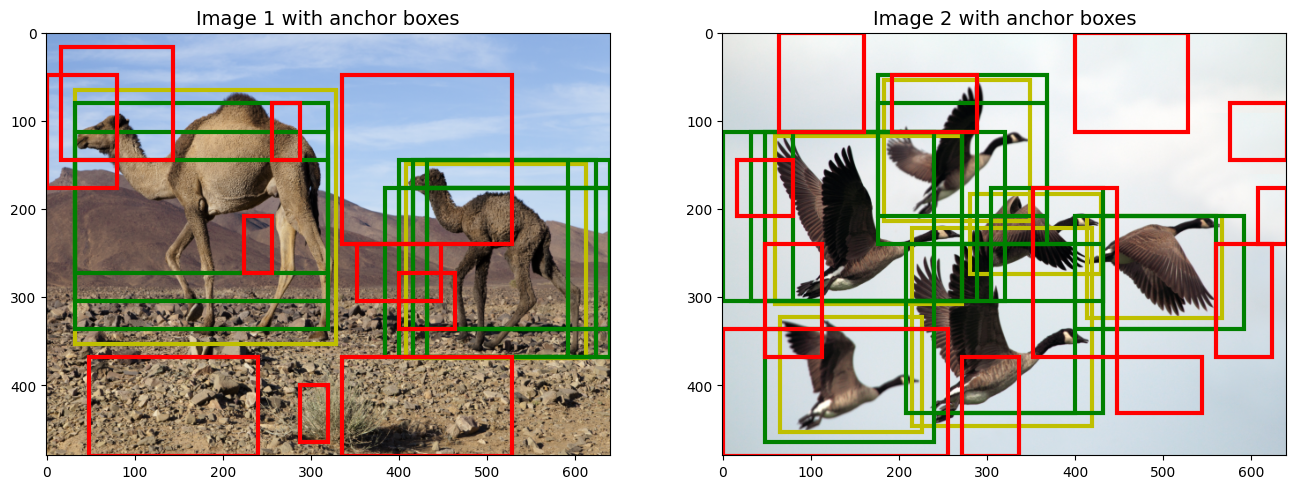

ground truth bbox = yellow, positive anchor = green, negative anchor = red


In [ ]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately

anc_idx_1 = torch.where(positive_anc_ind_sep == 0)[0]
anc_idx_2 = torch.where(positive_anc_ind_sep == 1)[0]

pos_anc_1 = pos_anc_proj[anc_idx_1]
pos_anc_2 = pos_anc_proj[anc_idx_2]

neg_anc_1 = neg_anc_proj[anc_idx_1]
neg_anc_2 = neg_anc_proj[anc_idx_2]

nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all.cpu(), fig, axes)

# plot groundtruth bboxes
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0])
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox(pos_anc_1, fig, axes[0], color='g')
fig, _ = display_bbox(pos_anc_2, fig, axes[1], color='g')

# plot negative anchor boxes
fig, _ = display_bbox(neg_anc_1, fig, axes[0], color='r')
fig, _ = display_bbox(neg_anc_2, fig, axes[1], color='r')

axes[0].set_title("Image 1 with anchor boxes", fontsize=14)
axes[1].set_title("Image 2 with anchor boxes", fontsize=14)
plt.show()
print("ground truth bbox = yellow, positive anchor = green, negative anchor = red")

###Step 5: Predict objectness and offsets (RPN)

Define a 1 x 1 conv network to predict objectness score and box offsets for each anchor

In [ ]:
class ProposalModule(nn.Module):
  """
  RPN Proposal Module:
  Takes the feature map from backbone and predicts:
    - Objectness score (conf_scores) for each anchor
    - Regression offsets (dx, dy, dw, dh) for positive anchors
  """
  def __init__(self, in_features, hidden_dim=512, n_anchors=9, p_dropout=0.3):
    super().__init__()
    self.n_anchors = n_anchors

    # 3x3 conv to reduce channels and encode features
    self.conv1 = nn.Conv2d(in_features, hidden_dim, kernel_size=3, padding=1)
    self.dropout = nn.Dropout(p_dropout)

    # Head for predicting objectness score for each anchor
    self.conf_head = nn.Conv2d(hidden_dim, n_anchors, kernel_size=1)

    # Head for predicting bounding box offsets for each anchor
    self.reg_head = nn.Conv2d(hidden_dim, n_anchors * 4, kernel_size=1)

  def forward(self, feature_map, pos_anc_ind=None, neg_anc_ind=None, pos_anc_coords=None):
    """
    Forward pass.

    Args:
      feature_map: [B, C, H', W'] backbone feature map
      pos_anc_ind: [n_pos] indices of positive anchors (train mode)
      neg_anc_ind: [n_neg] indices of negative anchors (train mode)
      pos_anc_coords: [n_pos, 4] coordinates of positive anchors (train mode)

    Returns (train):
      conf_scores_pos: [n_pos] predicted scores for positive anchors
      conf_scores_neg: [n_neg] predicted scores for negative anchors
      offsets_pos: [n_pos, 4] predicted bbox offsets
      proposals: [n_pos, 4] adjusted boxes
    Returns (eval):
      conf_scores_pred: [B, n_anchors, H', W']
      reg_offsets_pred: [B, n_anchors*4, H', W']
    """

    mode = 'eval' if pos_anc_ind is None else 'train'

    # -----------------------------
    # Feature processing
    # -----------------------------
    out = self.conv1(feature_map)  # [B, hidden_dim, H', W']
    out = F.relu(self.dropout(out))

    # -----------------------------
    # Predict offsets and objectness
    # -----------------------------
    reg_offsets_pred = self.reg_head(out)  # [B, A*4, H', W']
    conf_scores_pred = self.conf_head(out)  # [B, A, H', W']

    if mode == 'train':
      # Flatten feature maps to 1D for indexing with anchor indices
      conf_scores_flat = conf_scores_pred.flatten()  # [B*H'*W'*A]
      reg_offsets_flat = reg_offsets_pred.contiguous().view(-1, 4)  # [B*H'*W'*A, 4]

      # Select positive/negative anchors
      conf_scores_pos = conf_scores_flat[pos_anc_ind]  # [n_pos]
      conf_scores_neg = conf_scores_flat[neg_anc_ind]  # [n_neg]
      offsets_pos = reg_offsets_flat[pos_anc_ind]      # [n_pos, 4]

      # Generate proposals (adjusted boxes) from positive anchors
      proposals = generate_proposals(pos_anc_coords, offsets_pos)  # [n_pos, 4]

      return conf_scores_pos, conf_scores_neg, offsets_pos, proposals

    else:
      return conf_scores_pred, reg_offsets_pred

###Step 6: Compute RPN loss

In [ ]:
def calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size):
  """
  Binary classification loss for RPN.

  Args:
      conf_scores_pos: [n_pos] predicted positive anchor scores
      conf_scores_neg: [n_neg] predicted negative anchor scores
      batch_size: B
  """
  target_pos = torch.ones_like(conf_scores_pos)
  target_neg = torch.zeros_like(conf_scores_neg)

  inputs = torch.cat((conf_scores_pos, conf_scores_neg))  # [n_pos + n_neg]
  targets = torch.cat((target_pos, target_neg))          # [n_pos + n_neg]

  loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='sum') / batch_size
  return loss


def calc_bbox_reg_loss(gt_offsets, reg_offsets_pos, batch_size):
  """
  Smooth L1 loss for RPN bounding box regression.

  Args:
      gt_offsets: [n_pos, 4] ground truth offsets
      reg_offsets_pos: [n_pos, 4] predicted offsets
      batch_size: B
  """
  assert gt_offsets.size() == reg_offsets_pos.size()
  loss = F.smooth_l1_loss(reg_offsets_pos, gt_offsets, reduction='sum') / batch_size
  return loss

###Step 7: Generate proposals and apply NMS

In [ ]:
def generate_proposals(anchors, offsets):
  """
  Apply predicted offsets to anchor boxes to generate proposals.

  Args:
    anchors: [N, 4] in xyxy format
    offsets: [N, 4] predicted (dx, dy, dw, dh)

  Returns:
    proposals: [N, 4] adjusted boxes in xyxy format
  """
  # Convert anchors to center format [cx, cy, w, h] for easy offset application
  anchors_cxcywh = ops.box_convert(anchors, in_fmt='xyxy', out_fmt='cxcywh')

  proposals_ = torch.zeros_like(anchors_cxcywh)
  # Apply offsets: dx, dy scaled by w,h; dw, dh as log-space scaling
  proposals_[:, 0] = anchors_cxcywh[:, 0] + offsets[:, 0] * anchors_cxcywh[:, 2]  # cx'
  proposals_[:, 1] = anchors_cxcywh[:, 1] + offsets[:, 1] * anchors_cxcywh[:, 3]  # cy'
  proposals_[:, 2] = anchors_cxcywh[:, 2] * torch.exp(offsets[:, 2])            # w'
  proposals_[:, 3] = anchors_cxcywh[:, 3] * torch.exp(offsets[:, 3])            # h'

  # Convert back to xyxy for later use
  proposals = ops.box_convert(proposals_, in_fmt='cxcywh', out_fmt='xyxy')
  return proposals

In [ ]:
class RegionProposalNetwork(nn.Module):
  """
  Faster R-CNN style Region Proposal Network.
  Steps are numbered continuously from training to inference.
  """
  def __init__(self, img_size, out_size, out_channels):
    super().__init__()

    # Image and feature map sizes
    self.img_height, self.img_width = img_size         # Input image size
    self.out_h, self.out_w = out_size                 # Feature map output size from backbone

    # Downsampling scale factor (used to project GT boxes to feature map)
    self.width_scale_factor = self.img_width // self.out_w
    self.height_scale_factor = self.img_height // self.out_h

    # Anchor box scales and aspect ratios
    self.anc_scales = [2, 4, 6]                       # relative sizes of anchors
    self.anc_ratios = [0.5, 1, 1.5]                   # aspect ratios
    self.n_anc_boxes = len(self.anc_scales) * len(self.anc_ratios)  # total anchors per feature map location

    # IoU thresholds for positive / negative anchors
    self.pos_thresh = 0.7
    self.neg_thresh = 0.3

    # Loss weights for classification and regression
    self.w_conf = 1
    self.w_reg = 5

    # Backbone feature extractor
    self.feature_extractor = FeatureExtractor()      # outputs [B, C, H', W']

    # Proposal module: predicts objectness and offsets for anchors
    self.proposal_module = ProposalModule(out_channels, n_anchors=self.n_anc_boxes)

  def forward(self, images, gt_bboxes, gt_classes):
    batch_size = images.size(0)  # B

    # -----------------------------
    # Step 1: Extract feature map from backbone
    # -----------------------------
    feature_map = self.feature_extractor(images)  # [B, C, H', W']

    # -----------------------------
    # Step 2: Generate anchor boxes
    # -----------------------------
    anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))  # [H', W']
    anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
    anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)  # [B, H', W', n_anchors, 4]

    # -----------------------------
    # Step 3: Project GT boxes to feature map scale
    # -----------------------------
    gt_bboxes_proj = project_bboxes(gt_bboxes, self.width_scale_factor, self.height_scale_factor, mode='p2a')  # [B, N_gt, 4]

    # -----------------------------
    # Step 4: Assign positive and negative anchors
    # -----------------------------
    positive_anc_ind, negative_anc_ind, GT_conf_scores, \
    GT_offsets, GT_class_pos, positive_anc_coords, \
    negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes)
    # Shapes:
    # positive_anc_ind: [n_pos]
    # negative_anc_ind: [n_neg]
    # GT_conf_scores: [n_pos]
    # GT_offsets: [n_pos, 4]
    # GT_class_pos: [n_pos]
    # positive_anc_coords: [n_pos, 4]
    # negative_anc_coords: [n_neg, 4]
    # positive_anc_ind_sep: [n_pos]

    # -----------------------------
    # Step 5: Predict objectness and offsets (RPN)
    # -----------------------------
    conf_scores_pos, conf_scores_neg, offsets_pos, proposals = self.proposal_module(
        feature_map, positive_anc_ind, negative_anc_ind, positive_anc_coords)
    # Shapes:
    # conf_scores_pos: [n_pos]
    # conf_scores_neg: [n_neg]
    # offsets_pos: [n_pos, 4]
    # proposals: [n_pos, 4]

    # -----------------------------
    # Step 6: Compute RPN losses
    # -----------------------------
    cls_loss = calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size)
    reg_loss = calc_bbox_reg_loss(GT_offsets, offsets_pos, batch_size)
    total_rpn_loss = self.w_conf * cls_loss + self.w_reg * reg_loss

    return total_rpn_loss, feature_map, proposals, positive_anc_ind_sep, GT_class_pos

  def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
    """
    Inference mode.
    Steps continue numbering from training forward pass.
    """
    batch_size = images.size(0)  # B

    # -----------------------------
    # Step 1: Extract feature map from backbone
    # -----------------------------
    feature_map = self.feature_extractor(images)  # [B, C, H', W']

    # -----------------------------
    # Step 2: Generate anchor boxes
    # -----------------------------
    anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
    anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
    anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)  # [B, H', W', n_anchors, 4]
    anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)  # [B, H'*W'*n_anchors, 4]

    # -----------------------------
    # Step 5: Predict objectness and offsets (RPN)
    # -----------------------------
    conf_scores_pred, offsets_pred = self.proposal_module(feature_map)
    conf_scores_pred = conf_scores_pred.reshape(batch_size, -1)      # [B, H'*W'*n_anchors]
    offsets_pred = offsets_pred.reshape(batch_size, -1, 4)           # [B, H'*W'*n_anchors, 4]

    # -----------------------------
    # Step 7: Generate proposals and apply NMS
    # -----------------------------
    proposals_final = []
    conf_scores_final = []
    for i in range(batch_size):
      conf_scores = torch.sigmoid(conf_scores_pred[i])  # [H'*W'*n_anchors]
      offsets = offsets_pred[i]                         # [H'*W'*n_anchors, 4]
      anc_boxes = anc_boxes_flat[i]                     # [H'*W'*n_anchors, 4]

      # Apply offsets to anchors to generate proposals
      proposals = generate_proposals(anc_boxes, offsets)  # [H'*W'*n_anchors, 4]

      # Filter proposals by confidence threshold
      conf_idx = torch.where(conf_scores >= conf_thresh)[0]
      conf_scores_pos = conf_scores[conf_idx]
      proposals_pos = proposals[conf_idx]

      # Apply NMS
      nms_idx = ops.nms(proposals_pos, conf_scores_pos, nms_thresh)
      conf_scores_pos = conf_scores_pos[nms_idx]
      proposals_pos = proposals_pos[nms_idx]

      proposals_final.append(proposals_pos)
      conf_scores_final.append(conf_scores_pos)

    return proposals_final, conf_scores_final, feature_map

###Step 8 & 9: ROI pooling / align proposals & Classifier forward


In [ ]:
class ClassificationModule(nn.Module):
  """
  Classification head for Fast R-CNN:
  Takes proposals from RPN and predicts object classes.
  """
  def __init__(self, out_channels, n_classes, roi_size, hidden_dim=512, p_dropout=0.3):
    super().__init__()
    self.roi_size = roi_size

    # ROI pooling followed by average pooling
    self.avg_pool = nn.AvgPool2d(self.roi_size)
    self.fc = nn.Linear(out_channels, hidden_dim)  # hidden layer
    self.dropout = nn.Dropout(p_dropout)

    # classification head
    self.cls_head = nn.Linear(hidden_dim, n_classes)

  def forward(self, feature_map, proposals_list, gt_classes=None):
    """
    Args:
      feature_map: [B, C, H', W'] backbone feature map
      proposals_list: list of [N_i, 4] proposals for each image
      gt_classes: [total_n_pos] ground truth class for positive proposals (train mode)

    Returns:
      Train: cross-entropy loss
      Eval: cls_scores [total_n_pos, n_classes]
    """
    mode = 'eval' if gt_classes is None else 'train'

    # -----------------------------
    # ROI Pooling + Avg Pooling
    # -----------------------------
    # Extract fixed-size features for each proposal
    roi_out = ops.roi_pool(feature_map, proposals_list, self.roi_size)  # [total_proposals, C, roi_h, roi_w]
    roi_out = self.avg_pool(roi_out)                                   # [total_proposals, C, 1, 1]

    # Flatten features for fully connected layer
    roi_out = roi_out.squeeze(-1).squeeze(-1)                           # [total_proposals, C]

    # -----------------------------
    # Hidden layer
    # -----------------------------
    out = self.fc(roi_out)                                              # [total_proposals, hidden_dim]
    out = F.relu(self.dropout(out))

    # -----------------------------
    # Classification head
    # -----------------------------
    cls_scores = self.cls_head(out)                                     # [total_proposals, n_classes]

    if mode == 'eval':
        return cls_scores

    # -----------------------------
    # Compute loss in train mode
    # -----------------------------
    cls_loss = F.cross_entropy(cls_scores, gt_classes.long())           # scalar
    return cls_loss


###Step 10 & 11: Compute classification loss & Compute total loss


In [ ]:
class TwoStageDetector(nn.Module):
  """
  Complete Faster R-CNN style detector:
  Steps continue numbering from RPN training to inference.
  """
  def __init__(self, img_size, out_size, out_channels, n_classes, roi_size):
    super().__init__()
    self.rpn = RegionProposalNetwork(img_size, out_size, out_channels)
    self.classifier = ClassificationModule(out_channels, n_classes, roi_size)

  def forward(self, images, gt_bboxes, gt_classes):
    """
    Training forward pass.
    Args:
      images: [B, C, H, W]
      gt_bboxes: [B, max_objects, 4]
      gt_classes: [B, max_objects]
    Returns:
      total_loss: sum of RPN loss + classification loss
    """
    batch_size = images.size(0)

    # -----------------------------
    # Step 1-6: RPN forward (training)
    # -----------------------------
    total_rpn_loss, feature_map, proposals, \
    positive_anc_ind_sep, GT_class_pos = self.rpn(images, gt_bboxes, gt_classes)
    # feature_map: [B, C, H', W']
    # proposals: [total_n_pos, 4]
    # positive_anc_ind_sep: [total_n_pos]
    # GT_class_pos: [total_n_pos]

    # -----------------------------
    # Step 8: ROI pooling / align proposals
    # -----------------------------
    # Shape per image: [n_pos_i, 4]
    pos_proposals_list = []
    for idx in range(batch_size):
      proposal_idxs = torch.where(positive_anc_ind_sep == idx)[0]
      proposals_sep = proposals[proposal_idxs].detach().clone()  # [n_pos_i, 4]
      pos_proposals_list.append(proposals_sep)

    # -----------------------------
    # Step 9: Classifier forward
    # -----------------------------
    # Output: classification loss scalar
    cls_loss = self.classifier(feature_map, pos_proposals_list, GT_class_pos)

    # -----------------------------
    # Step 10 & 11: Compute classification loss & Compute total loss
    # -----------------------------
    total_loss = cls_loss + total_rpn_loss

    return total_loss

  def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
    """
    Inference forward pass.
    Args:
      images: [B, C, H, W]
      conf_thresh: threshold for objectness
      nms_thresh: NMS IoU threshold
    Returns:
      proposals_final: list of [n_prop_i, 4] per image
      conf_scores_final: list of [n_prop_i] per image
      classes_final: list of [n_prop_i] predicted classes per image
    """
    batch_size = images.size(0)

    # -----------------------------
    # Step 7: RPN inference (RPN inference)
    # -----------------------------
    proposals_final, conf_scores_final, feature_map = self.rpn.inference(images, conf_thresh, nms_thresh)
    # proposals_final: list of [n_prop_i, 4]
    # conf_scores_final: list of [n_prop_i]
    # feature_map: [B, C, H', W']

    # -----------------------------
    # Step 8: ROI pooling / align proposals
    # -----------------------------
    # Flatten proposals for ROI pooling
    cls_scores = self.classifier(feature_map, proposals_final)
    # cls_scores: [total_n_prop, n_classes]

    # -----------------------------
    # Step 9: Classifier forward
    # -----------------------------
    cls_probs = F.softmax(cls_scores, dim=-1)      # [total_n_prop, n_classes]
    classes_all = torch.argmax(cls_probs, dim=-1)  # [total_n_prop]

    # -----------------------------
    # Step 12: final prediction
    # -----------------------------
    classes_final = []
    c = 0
    for i in range(batch_size):
      n_proposals = len(proposals_final[i])
      classes_final.append(classes_all[c: c+n_proposals])
      c += n_proposals

    return proposals_final, conf_scores_final, classes_final

In [ ]:
img_size = (img_height, img_width)    # input shape
out_size = (out_h, out_w)             # output shape
n_classes = len(name2idx) - 1         # number of class (exclude pad idx)
roi_size = (2, 2)                     # ROI size

detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size)

In [ ]:
detector.eval()
total_loss = detector(img_batch, gt_bboxes_batch, gt_classes_batch)
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)

In [ ]:
from tqdm import tqdm
import torch.optim as optim

def training_loop(model, learning_rate, train_dataloader, n_epochs):
  """
  Train Faster R-CNN model.
  """
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  model.train()
  loss_list = []

  for i in tqdm(range(n_epochs)):
    total_loss = 0
    for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
      # forward pass
      loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    loss_list.append(total_loss)

  return loss_list

In [ ]:
learning_rate = 1e-3
n_epochs = 1000

loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs)

100%|██████████| 1000/1000 [2:05:14<00:00,  7.51s/it]


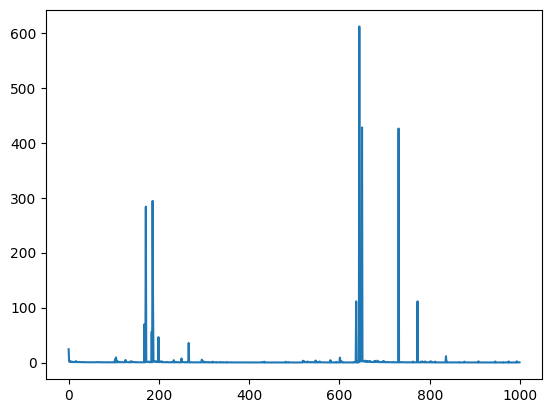

In [ ]:
plt.plot(loss_list)

In [ ]:
torch.save(detector.state_dict(), "model.pt")

###Step 12: Inference


In [ ]:
detector.eval()
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch, conf_thresh=0.99, nms_thresh=0.05)

In [ ]:
# project proposals to the image space
prop_proj_1 = project_bboxes(proposals_final[0].detach(), width_scale_factor, height_scale_factor, mode='a2p')
prop_proj_2 = project_bboxes(proposals_final[1].detach(), width_scale_factor, height_scale_factor, mode='a2p')

# get classes
classes_pred_1 = [idx2name[cls] for cls in classes_final[0].tolist()]
classes_pred_2 = [idx2name[cls] for cls in classes_final[1].tolist()]

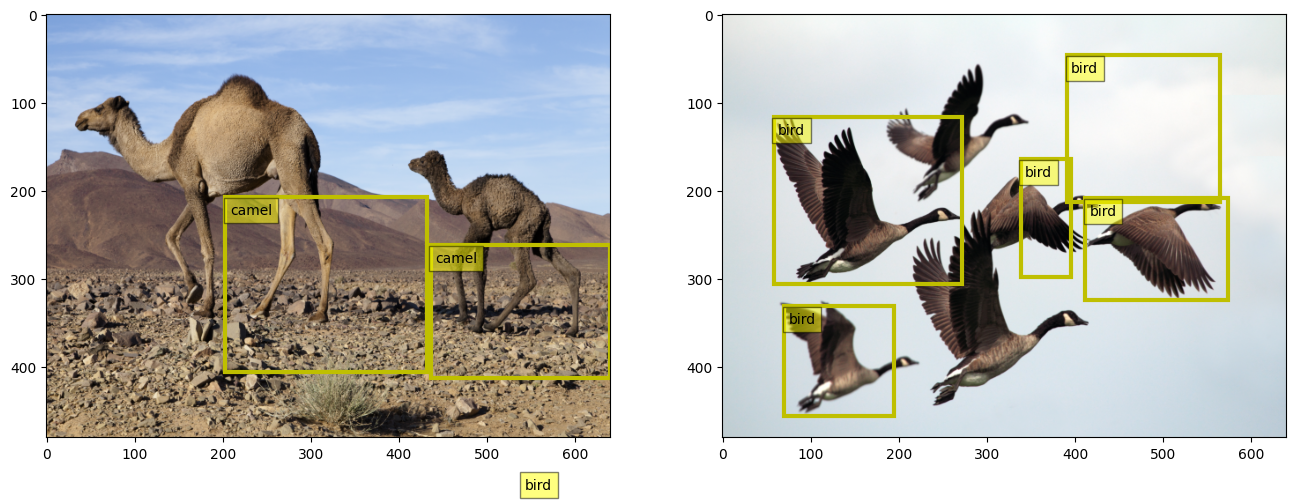

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch, fig, axes)
fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)

## Reference

[Understanding and Implementing Faster R-CNN: A Step-By-Step Guide](https://medium.com/data-science/understanding-and-implementing-faster-r-cnn-a-step-by-step-guide-11acfff216b0)